In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
dataset, info = tfds.load(
    "cats_vs_dogs",
    with_info=True,
    as_supervised=True
)

total_samples = info.splits['train'].num_examples
print("Total samples:", total_samples)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.MFHZ2F_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Total samples: 23262


In [3]:
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_ds = dataset['train'].take(train_size)
temp_ds = dataset['train'].skip(train_size)

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

train_ds = train_ds.map(preprocess).map(
    lambda x, y: (data_augmentation(x), y)
)

val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [6]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

baseline_model.fit(train_ds, validation_data=val_ds, epochs=5)

baseline_acc = baseline_model.evaluate(test_ds)[1]
print("Baseline Test Accuracy:", baseline_acc)


Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 235s 456ms/step - accuracy: 0.5537 - loss: 1.0882 - val_accuracy: 0.6449 - val_loss: 0.6317
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 232s 455ms/step - accuracy: 0.6583 - loss: 0.6249 - val_accuracy: 0.6999 - val_loss: 0.5779
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 228s 447ms/step - accuracy: 0.6930 - loss: 0.5861 - val_accuracy: 0.7400 - val_loss: 0.5221
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 229s 450ms/step - accuracy: 0.7273 - loss: 0.5491 - val_accuracy: 0.7633 - val_loss: 0.4917
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 228s 448ms/step - accuracy: 0.7497 - loss: 0.5162 - val_accuracy: 0.7939 - val_loss: 0.4574
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.7928 - loss: 0.4530
Baseline Test Accuracy: 0.7893982529640198


In [7]:
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 278s 520ms/step - accuracy: 0.5428 - loss: 0.7084 - val_accuracy: 0.6162 - val_loss: 0.6651
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 254s 499ms/step - accuracy: 0.5759 - loss: 0.6747 - val_accuracy: 0.6154 - val_loss: 0.6573
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 253s 497ms/step - accuracy: 0.5850 - loss: 0.6713 - val_accuracy: 0.6154 - val_loss: 0.6563
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 253s 498ms/step - accuracy: 0.5929 - loss: 0.6686 - val_accuracy: 0.6271 - val_loss: 0.6516
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 253s 497ms/step - accuracy: 0.6050 - loss: 0.6670 - val_accuracy: 0.6231 - val_loss: 0.6531


In [ ]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 297s 547ms/step - accuracy: 0.6252 - loss: 0.8296 - val_accuracy: 0.7226 - val_loss: 0.5419
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 264s 519ms/step - accuracy: 0.7066 - loss: 0.5703 - val_accuracy: 0.7438 - val_loss: 0.5201
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 264s 518ms/step - accuracy: 0.7215 - loss: 0.5512 - val_accuracy: 0.7521 - val_loss: 0.5124
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 264s 519ms/step - accuracy: 0.7313 - loss: 0.5392 - val_accuracy: 0.7592 - val_loss: 0.5004
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 265s 520ms/step - accuracy: 0.7368 - loss: 0.5277 - val_accuracy: 0.7716 - val_loss: 0.4808


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Transfer Learning Test Accuracy:", test_acc)


110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.7756 - loss: 0.4817
Transfer Learning Test Accuracy: 0.7750716209411621


In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
last_conv_layer = "conv5_block3_out"

grad_model = tf.keras.models.Model(
    model.inputs,
    [model.get_layer(last_conv_layer).output, model.output]
)

image, label = next(iter(test_ds))
img = image[0]

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(tf.expand_dims(img, axis=0))
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)


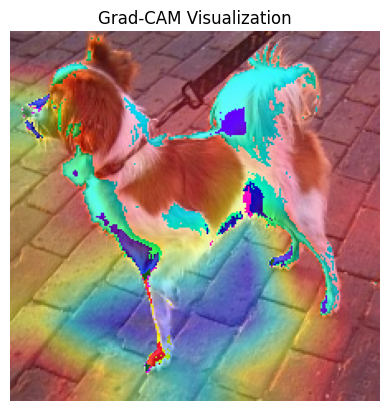

In [ ]:
heatmap = cv2.resize(heatmap.numpy(), (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img.numpy() * 255

plt.imshow(superimposed_img.astype("uint8"))
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.show()


In [ ]:
model.save("cats_vs_dogs_resnet50.h5")
